In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

use_cuda = torch.cuda.is_available()

In [2]:
!pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from torchdiffeq import odeint

In [4]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, t_vec, z0, dynamics, theta_flat):
        
        z = odeint(dynamics, z0, t_vec)

        ctx.dynamics = dynamics
        ctx.save_for_backward(t_vec, z.clone(), theta_flat)

        return z

    @staticmethod
    def backward(ctx, dLdz_f):

        t_vec, z, theta = ctx.saved_tensors
        n_dim = z.size(1)
        n_param = theta.size(1)
        t_len = t_vec.size(0)

        dynamics = ctx.dynamics
        def aug_dynamics(t_i, z_aug):
            z_a, a_a = z_aug[:,:n_dim], z_aug[:,n_dim:2*n_dim]
            with torch.set_grad_enabled(True):
                z_a = z_a.detach().requires_grad_(True)
                dzdt = dynamics(t_vec, z_a)
                adfdz, *adfdtheta = torch.autograd.grad(dzdt, 
                                                        (z_a,)+tuple(dynamics.parameters()),
                                                        grad_outputs=(a_a),
                                                        retain_graph=True)
                # print(adfdtheta)
            if adfdtheta is not None:
                adfdtheta = torch.cat([p.flatten() for p in adfdtheta]).unsqueeze(0)
            return torch.cat((dzdt, -adfdz, -adfdtheta), dim=1)


        with torch.no_grad():

            adj_z = torch.zeros((1, n_dim)).to(dLdz_f)
            adj_theta = torch.zeros((1, n_param)).to(dLdz_f)

            t_rev = torch.flip(t_vec, (0,))
            z_rev = torch.flip(z, (0,))
            dLdz_rev = torch.flip(dLdz_f, (0,))

            for i in range(t_len - 1):
                z_i = z_rev[i:i+1,:]
                t_i = t_rev[i]

                dLdz_i = dLdz_rev[i]
                adj_z += dLdz_i

                s0 = torch.cat((z_i, adj_z, torch.zeros(1, n_param).to(z)), dim=1)
                s_1 = odeint(aug_dynamics, s0, t_rev[i:i+2])
                s_1 = s_1.squeeze(1)        
                adj_z[:] = s_1[-1, n_dim:2*n_dim]
                adj_theta[:] += s_1[-1, 2*n_dim:2*n_dim + n_param]

            adj_z += dLdz_rev[0]
            # print(adj_theta)
            return None, adj_z, None, adj_theta

In [5]:
class NNODEF(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super(NNODEF, self).__init__()
        self.lin1 = nn.Linear(in_dim, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, t, x):
        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [6]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        self.func = func

    def forward(self, z0, t, return_whole_sequence=False):
        t = t.to(z0)
        theta = torch.cat([p.flatten() for p in self.func.parameters()]).unsqueeze(0)
        z = ODEAdjoint.apply(t, z0, self.func, theta)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [7]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            # o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            # z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [8]:
def get_batch(t, obs, batch_size=10, sequential=False):
    ind = np.random.choice(np.arange(len(t)), batch_size, replace=False)
    if sequential:
        ind = np.arange(batch_size) + np.min(np.array([ind[0], len(t) - batch_size])) 
    else:
        ind = np.sort(ind)
    tb = t[ind]
    obsb = obs[ind,:]
    return tb, obsb

In [25]:
def train_model(t, obs, model, n_steps, plot_freq=10, seq=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_val = []
    for i in range(n_steps):
        tb, ob = get_batch(t, obs.detach(), sequential=seq)
        zt = model(ob[0,:], tb, return_whole_sequence=True)
        loss = F.mse_loss(zt, ob)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        loss_val.append(loss.item())
        optimizer.step()

        if i % plot_freq == 0:
            z_p = model(obs[0,:], t, return_whole_sequence=True)

            plt.plot(t, z_p.detach())
            plt.plot(t, obs, 'o')
            plt.show()
            clear_output(wait=True)
    return loss_val

In [26]:
class LinODE(nn.Module):
    def __init__(self, W):
        super(LinODE, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        return self.lin(x)
W = torch.tensor([[0., 1.], [-1., -0.2]])
dyn_fun = LinODE(W)

In [30]:
z0 = Variable(torch.tensor([1., 1.]))

t_span = torch.linspace(0., 10., 50)
t_noise = torch.rand((1, 48))*0.1 - 0.05
t_noise = torch.cat((Tensor([[0.]]), t_noise, Tensor([[0.]])),dim=1)
t_span += t_noise.squeeze(0)

obs_noise = torch.normal(torch.zeros((50,2)), 0.1*torch.ones((50,2)))
obs = odeint(dyn_fun, z0, t_span) + obs_noise

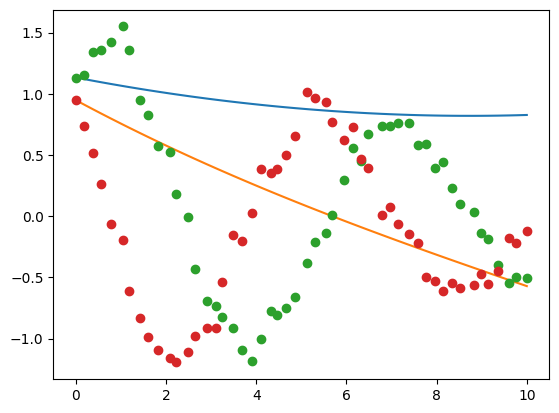

In [43]:
train_fun = NNODEF(2,10)
trained_seq = NeuralODE(train_fun)

error_seq= train_model(t_span, obs.detach(), trained_seq, 1, plot_freq=20, seq=True)

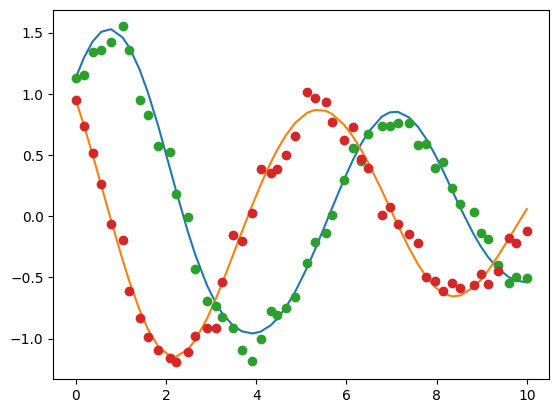

In [36]:
train_fun_rand = NNODEF(2,10)
trained_rand = NeuralODE(train_fun_rand)

error_rand = train_model(t_span, obs.detach(), trained_rand, 300, plot_freq=20, seq=False)

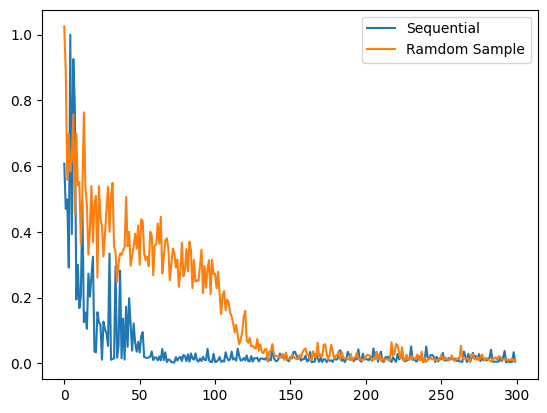

In [42]:
plt.plot(error_seq, label='Sequential')
plt.plot(error_rand, label='Ramdom Sample')
plt.legend()

In [39]:
t_span_long = torch.linspace(0., 20., 100)

obs_long = odeint(dyn_fun, z0, t_span_long)
pred_long = trained_rand(z0, t_span_long, return_whole_sequence=True)

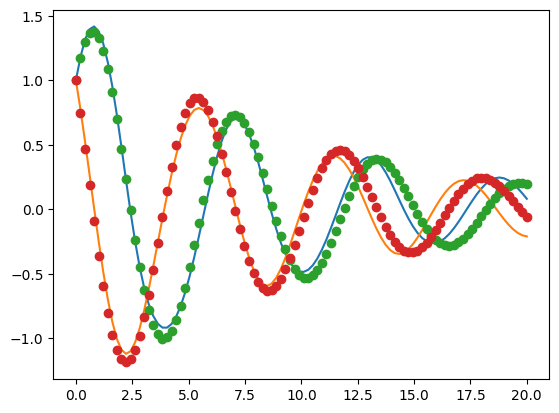

In [40]:
plt.plot(t_span_long, pred_long.detach())
plt.plot(t_span_long, obs_long.detach(), 'o')


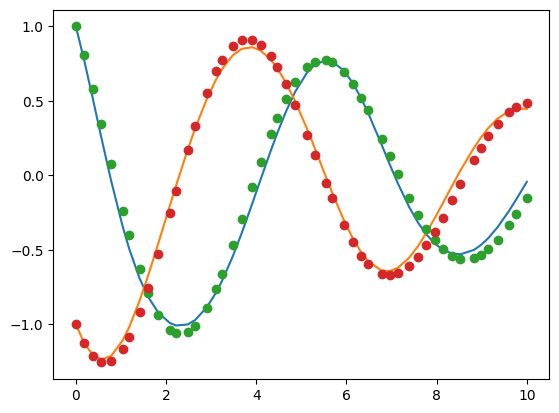

In [41]:
z1 = Variable(torch.tensor([1., -1.]))
obs1 = odeint(dyn_fun, z1, t_span)
pred1 = trained_rand(z1, t_span, return_whole_sequence=True)

plt.plot(t_span, pred1.detach())
plt.plot(t_span, obs1.detach(), 'o')